In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings('ignore')

In [67]:
# Load your dataset
df = pd.read_excel("v1.0-189data-final.xlsx")

def pct_change(start, end):
    """Compute percentage change safely."""
    if pd.isna(start) or pd.isna(end):
        return np.nan
    if start == 0:
        return np.nan  # avoid division by zero
    return (end - start) / start

# Identify all 2011 and 2021 columns
cols_2011 = [c for c in df.columns if c.endswith(("11", "2011"))]
cols_2021 = [c for c in df.columns if c.endswith(("21", "2021"))]

# Match 2011 and 2021 columns by base name
pairs = {}

for c11 in cols_2011:
    base = c11.replace("_2011", "").replace("_11", "")
    for c21 in cols_2021:
        if c21.startswith(base):
            pairs[base] = (c11, c21)

# Compute % change for each matched pair
for base, (col11, col21) in pairs.items():
    df[f"pct_change_{base}"] = df.apply(
        lambda row: pct_change(row[col11], row[col21]), axis=1
    )

# Inspect the new columns
print(df.filter(like="pct_change_").head())



   pct_change_price  pct_change_sales  pct_change_owner_occupied_pct  \
0          0.663368         -0.027778                      -0.060285   
1          0.549763         -0.259259                      -0.175298   
2          0.270140         -0.400000                      -0.071997   
3               NaN         -0.733333                      -0.136433   
4          0.704782          0.500000                      -0.239984   

   pct_change_social_rent_pct  pct_change_private_rent_pct  \
0                   -0.480427                     0.190600   
1                    0.509091                     0.582348   
2                   -0.252569                     0.420743   
3                    0.006769                    -0.041652   
4                    0.816988                     0.374532   

   pct_change_detached_semi_pct  pct_change_terraced_pct  \
0                      0.568019                 0.626094   
1                      2.021845                -0.087151   
2             

### Check for and drop missing values in % change price, flat purpose built, semi-detached, net income
 LSOAs removed due to missing pct_change_price: 380
 LSOAs removed due to missing pct_change_flat_purpose_built_pct: 5
 LSOAs removed due to missing pct_change_detached_semi_pct: 3
 LSOAs removed due to missing pct_change_net_inc_beforehousing: 101 

In [3]:
#Count LSOAs with missing vals
missing_price = df["pct_change_price"].isna().sum()
missing_flats = df["pct_change_flat_purpose_built_pct"].isna().sum()
missing_detached = df["pct_change_detached_semi_pct"].isna().sum()
missing_income = df["pct_change_net_inc_beforehousing"].isna().sum()

print("LSOAs removed due to missing pct_change_price:", missing_price)
print("LSOAs removed due to missing pct_change_flat_purpose_built_pct:", missing_flats)
print("LSOAs removed due to missing pct_change_detached_semi_pct:", missing_detached)
print("LSOAs removed due to missing pct_change_net_inc_beforehousing:", missing_income)

# Drop rows with missing vals
df = df.dropna(subset=[
    "pct_change_price",
    "pct_change_flat_purpose_built_pct",
    "pct_change_detached_semi_pct",
    "pct_change_net_inc_beforehousing"
]).reset_index(drop=True)


LSOAs removed due to missing pct_change_price: 380
LSOAs removed due to missing pct_change_flat_purpose_built_pct: 5
LSOAs removed due to missing pct_change_detached_semi_pct: 3
LSOAs removed due to missing pct_change_net_inc_beforehousing: 101


In [4]:
## Also remove cols pct_change_flat_converted_pct & pct_change_social_rent_pct, due to 67 and 30 missing values, respectively
cols_to_drop = [
    c for c in df.columns
    if c.startswith("price_") and c != "price_2011"

]

# Add the two problematic pct_change variables
cols_to_drop += [
    "pct_change_flat_converted_pct",
    "pct_change_social_rent_pct"
]

print("Dropping these columns:")
for c in cols_to_drop:
    print("  -", c)

# Drop them from df itself so they cannot reappear later
df = df.drop(columns=cols_to_drop, errors="ignore")

# Build X from the cleaned df
X = df.drop(columns=["pct_change_price"])


Dropping these columns:
  - price_2006
  - price_2007
  - price_2008
  - price_2009
  - price_2010
  - price_2012
  - price_2013
  - price_2014
  - price_2015
  - price_2016
  - price_2017
  - price_2018
  - price_2019
  - price_2020
  - price_2021
  - price_2022
  - pct_change_flat_converted_pct
  - pct_change_social_rent_pct


Add dummies for LA names

In [5]:
# One-hot encode borough names
df = pd.get_dummies(df, columns=["la_name"], drop_first=True)

# Convert boolean dummy variables to integers
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)


Feature selection etc:

### Methodological note: Simultaneity and scope of analysis

**Important caveat:** The features used in this analysis (percentage changes 2011-2021) are *contemporaneous* with the target variable (house price growth 2011-2021). This means the model captures **associative relationships** — which neighbourhood characteristics co-move with price growth — rather than causal or predictive relationships in a forecasting sense.

For example, rising house prices may *cause* demographic shifts (e.g., gentrification attracting professionals), not only the reverse. A truly predictive model would require lagged features (e.g., 2001-2011 changes predicting 2011-2021 price growth). This analysis is scoped as a **descriptive/associative study** to identify which factors are most strongly correlated with price growth patterns across London LSOAs.

Additionally, `pct_change_sales` (change in transaction volume) is excluded from the feature set as it is a direct component of the housing market and is mechanically related to price changes, risking endogeneity.

In [6]:
## Point to price growth as target variable
y = df["pct_change_price"]

In [ ]:
## Build feature matrix
## Exclude pct_change_sales (quasi-endogenous: transaction volume is part of the housing market itself)
feature_cols = [c for c in df.columns 
                if (
        c.startswith("pct_change_") 
        and "price" not in c
        and c != "pct_change_sales")  # exclude sales volume (endogenous)
                or c in ["price_2011", "healthy_assets_index", "area_hectares", "public_transport_mean_score", "transport_bank_mins", "net_inc_beforehousing_2011"]
                or c.startswith("la_name_")  # include borough dummies
]   

X = df[feature_cols]

In [38]:
print(feature_cols)


['area_hectares', 'healthy_assets_index', 'price_2011', 'public_transport_mean_score', 'net_inc_beforehousing_2011', 'transport_bank_mins', 'pct_change_sales', 'pct_change_owner_occupied_pct', 'pct_change_private_rent_pct', 'pct_change_detached_semi_pct', 'pct_change_terraced_pct', 'pct_change_flat_purpose_built_pct', 'pct_change_degree_pct', 'pct_change_no_quals_pct', 'pct_change_employed_pct', 'pct_change_self_employed_pct', 'pct_change_unemployed_pct', 'pct_change_retired_pct', 'pct_change_professional_pct', 'pct_change_routine_pct', 'pct_change_children_pct', 'pct_change_young_adults_pct', 'pct_change_elderly_pct', 'pct_change_not_deprived_pct', 'pct_change_deprived_3plus_pct', 'pct_change_no_car_pct', 'pct_change_commute_tube_rail_pct', 'pct_change_commute_bus_pct', 'pct_change_commute_car_pct', 'pct_change_commute_cycle_walk_pct', 'pct_change_wfh_pct', 'pct_change_single_person_pct', 'pct_change_couple_no_kids_pct', 'pct_change_families_with_kids_pct', 'pct_change_overcrowded_pct

### Multicollinearity diagnostics

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ── 1. Correlation heatmap for pct_change features ──
pct_cols = [c for c in feature_cols if c.startswith("pct_change_")]
corr_matrix = X[pct_cols].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap="coolwarm", center=0,
            annot=False, fmt=".2f", linewidths=0.5,
            xticklabels=True, yticklabels=True)
plt.title("Correlation Matrix: Percentage Change Features", fontsize=14, fontweight="bold")
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# ── 2. Flag highly correlated pairs (|r| > 0.7) ──
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        r = corr_matrix.iloc[i, j]
        if abs(r) > 0.7:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], round(r, 3)))

if high_corr:
    print("Highly correlated feature pairs (|r| > 0.7):")
    for f1, f2, r in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {f1}  <->  {f2}  :  r = {r}")
else:
    print("No feature pairs with |r| > 0.7 found.")

# ── 3. VIF for non-dummy numeric features ──
numeric_cols = [c for c in feature_cols if not c.startswith("la_name_")]
X_vif = X[numeric_cols].copy()
X_vif = X_vif.dropna()  # VIF requires no missing values

vif_data = pd.DataFrame({
    "Feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False)

print("\nVariance Inflation Factors (VIF):")
print("  VIF > 10 suggests serious multicollinearity")
print("  VIF > 5 suggests moderate multicollinearity\n")
print(vif_data.to_string(index=False))

In [8]:
## Create train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


### Add OLS estimation

In [ ]:
# Add constant for intercept
X_train_ols = sm.add_constant(X_train)
X_test_ols = sm.add_constant(X_test)

# Fit OLS on training data
ols_model = sm.OLS(y_train, X_train_ols).fit()

# Predict on test set
y_pred_ols = ols_model.predict(X_test_ols)

# Evaluate
ols_mse = mean_squared_error(y_test, y_pred_ols)
ols_r2 = r2_score(y_test, y_pred_ols)

print("OLS Test MSE:", ols_mse)
print("OLS Test R²:", ols_r2)

# ── OLS Diagnostics ──
print("\n" + "=" * 80)
print("OLS REGRESSION SUMMARY")
print("=" * 80)
print(ols_model.summary())

# Key diagnostic flags
print("\n── Diagnostic Flags ──")
cond_num = ols_model.condition_number
print(f"Condition number: {cond_num:.1f}", 
      "(WARNING: multicollinearity likely)" if cond_num > 1000 else "(acceptable)")
print(f"F-statistic: {ols_model.fvalue:.4f}  (p = {ols_model.f_pvalue:.4e})")
print(f"Adjusted R²: {ols_model.rsquared_adj:.4f}")
print(f"Number of observations: {int(ols_model.nobs)}")
print(f"Number of parameters: {len(ols_model.params)}")
print(f"Observations per parameter: {ols_model.nobs / len(ols_model.params):.1f}",
      "(WARNING: very low ratio)" if ols_model.nobs / len(ols_model.params) < 10 else "")

### Simple regression tree (roughly in line with tutorial code)

In [11]:
print("🌳 Training single decision tree (predicting LSOA house‑price growth)...\n")

# Train tree
tree_baseline = DecisionTreeRegressor(
    random_state=42,
    min_samples_leaf=20
)
tree_baseline.fit(X_train, y_train)

# Predictions
y_train_pred_tree = tree_baseline.predict(X_train)
y_test_pred_tree = tree_baseline.predict(X_test)

# Evaluate
train_mse_tree = mean_squared_error(y_train, y_train_pred_tree)
test_mse_tree = mean_squared_error(y_test, y_test_pred_tree)
test_r2_tree = r2_score(y_test, y_test_pred_tree)

# Naive baseline (predict mean growth)
naive_pred = np.full(len(y_test), y_train.mean())
naive_mse = mean_squared_error(y_test, naive_pred)

print("📊 Single Tree Performance:")
print(f"   Training MSE: {train_mse_tree:.6f}")
print(f"   Test MSE: {test_mse_tree:.6f}")
print(f"   Test R²: {test_r2_tree:.4f}")

print("\n📊 Naive Baseline (Historical Mean):")
print(f"   Test MSE: {naive_mse:.6f}")
print(f"\n✅ Tree improves over naive by: {(1 - test_mse_tree/naive_mse)*100:.1f}%")

print("\n🌳 Tree Statistics:")
print(f"   Number of leaves: {tree_baseline.get_n_leaves()}")
print(f"   Max depth: {tree_baseline.get_depth()}")

🌳 Training single decision tree (predicting LSOA house‑price growth)...

📊 Single Tree Performance:
   Training MSE: 0.098458
   Test MSE: 0.217982
   Test R²: 0.0403

📊 Naive Baseline (Historical Mean):
   Test MSE: 0.227278

✅ Tree improves over naive by: 4.1%

🌳 Tree Statistics:
   Number of leaves: 128
   Max depth: 16


### Random Forest (after simple tree model - roughly in line with lecture content)

In [12]:
print("🌲🌲🌲 Training Random Forest...\n")

rf_model = RandomForestRegressor(
    n_estimators=500,        # number of trees
    max_features='sqrt',     # good default for tabular data
    min_samples_leaf=20,     # prevents overfitting
    n_jobs=-1,               # use all CPU cores
    random_state=42,
    oob_score=True           # out-of-bag validation
)

print("⏳ Training Random Forest...")
rf_model.fit(X_train, y_train)
print("✅ Training complete!\n")

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluation
train_mse_rf = mean_squared_error(y_train, y_train_pred_rf)
test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
oob_score = rf_model.oob_score_

print("📊 Random Forest Performance:")
print(f"   Training MSE: {train_mse_rf:.6f}")
print(f"   Test MSE: {test_mse_rf:.6f}")
print(f"   Test R²: {test_r2_rf:.4f}")
print(f"   OOB R² Score: {oob_score:.4f}")

print("\n📈 Improvement over single tree:",
      f"{(1 - test_mse_rf/test_mse_tree)*100:.1f}%")

print("📈 Improvement over naive baseline:",
      f"{(1 - test_mse_rf/naive_mse)*100:.1f}%")

print("\n💡 Out-of-Bag (OOB) score gives a free validation estimate.")
print("   Each tree trains on ~63% of rows and validates on the rest.")


🌲🌲🌲 Training Random Forest...

⏳ Training Random Forest...
✅ Training complete!

📊 Random Forest Performance:
   Training MSE: 0.115268
   Test MSE: 0.197828
   Test R²: 0.1290
   OOB R² Score: 0.1643

📈 Improvement over single tree: 9.2%
📈 Improvement over naive baseline: 13.0%

💡 Out-of-Bag (OOB) score gives a free validation estimate.
   Each tree trains on ~63% of rows and validates on the rest.


### Hyperparameter tuning

In [13]:
print("🔍 Hyperparameter tuning for Random Forest...\n")
print("⚠️ This may take 2–4 minutes depending on CPU.\n")

from sklearn.model_selection import GridSearchCV, KFold

# Parameter grid (kept tight to avoid long runtimes)
param_grid_rf = {
    'n_estimators': [300, 500],
    'max_features': [4, 5, 'sqrt'],
    'min_samples_leaf': [10, 20, 30]
}

# K-fold CV (LSOAs are not time series)
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Grid search
rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid_rf,
    cv=cv,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

print("⏳ Running grid search...")
rf_grid.fit(X_train, y_train)
print("✅ Grid search complete!\n")

# Best parameters
print("🎯 Best parameters found:")
for param, value in rf_grid.best_params_.items():
    print(f"   {param}: {value}")

# Evaluate tuned model
best_rf = rf_grid.best_estimator_
y_test_pred_rf_tuned = best_rf.predict(X_test)

test_mse_rf_tuned = mean_squared_error(y_test, y_test_pred_rf_tuned)
test_r2_rf_tuned = r2_score(y_test, y_test_pred_rf_tuned)

print("\n📊 Tuned Random Forest Performance:")
print(f"   Test MSE: {test_mse_rf_tuned:.6f}")
print(f"   Test R²: {test_r2_rf_tuned:.4f}")

print("\n📈 Improvement from tuning:",
      f"{(1 - test_mse_rf_tuned/test_mse_rf)*100:.1f}%")


🔍 Hyperparameter tuning for Random Forest...

⚠️ This may take 2–4 minutes depending on CPU.

⏳ Running grid search...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
✅ Grid search complete!

🎯 Best parameters found:
   max_features: sqrt
   min_samples_leaf: 10
   n_estimators: 500

📊 Tuned Random Forest Performance:
   Test MSE: 0.195997
   Test R²: 0.1371

📈 Improvement from tuning: 0.9%


### Gradient boosting (after RF tuning)

In [14]:
print("🚀 Training Gradient Boosting Machine...\n")

gbm_model = GradientBoostingRegressor(
    n_estimators=1000,        # many weak learners
    learning_rate=0.01,       # slow, stable learning
    max_depth=4,              # shallow trees
    min_samples_leaf=20,
    subsample=0.8,            # stochastic gradient boosting
    random_state=42,
    validation_fraction=0.2,  # early stopping
    n_iter_no_change=50,
    verbose=0
)

print("⏳ Training GBM (this may take 1–2 minutes)...")
gbm_model.fit(X_train, y_train)
print(f"✅ Training complete! Used {gbm_model.n_estimators_} trees (after early stopping)\n")

# Predictions
y_train_pred_gbm = gbm_model.predict(X_train)
y_test_pred_gbm = gbm_model.predict(X_test)

# Evaluation
train_mse_gbm = mean_squared_error(y_train, y_train_pred_gbm)
test_mse_gbm = mean_squared_error(y_test, y_test_pred_gbm)
test_r2_gbm = r2_score(y_test, y_test_pred_gbm)

print("📊 Gradient Boosting Performance:")
print(f"   Training MSE: {train_mse_gbm:.6f}")
print(f"   Test MSE: {test_mse_gbm:.6f}")
print(f"   Test R²: {test_r2_gbm:.4f}")

print("\n📈 Improvement over single tree:",
      f"{(1 - test_mse_gbm/test_mse_tree)*100:.1f}%")

print("📈 Improvement over Random Forest:",
      f"{(1 - test_mse_gbm/test_mse_rf)*100:.1f}%")

print("📈 Improvement over naive baseline:",
      f"{(1 - test_mse_gbm/naive_mse)*100:.1f}%")

print("\n💡 Training/Test gap:",
      f"{abs(train_mse_gbm - test_mse_gbm):.6f}")
print("   Small gap = good generalization!")


🚀 Training Gradient Boosting Machine...

⏳ Training GBM (this may take 1–2 minutes)...
✅ Training complete! Used 748 trees (after early stopping)

📊 Gradient Boosting Performance:
   Training MSE: 0.087427
   Test MSE: 0.178919
   Test R²: 0.2123

📈 Improvement over single tree: 17.9%
📈 Improvement over Random Forest: 9.6%
📈 Improvement over naive baseline: 21.3%

💡 Training/Test gap: 0.091492
   Small gap = good generalization!


### Advancing GBM tuning (in-line with tutorial)

In [15]:
print("🔍 Hyperparameter tuning for Gradient Boosting...\n")
print("⚠️ Focused grid to balance time and performance.\n")

# Focused parameter grid
param_grid_gbm = {
    'learning_rate': [0.01, 0.05],
    'n_estimators': [500, 1000, 2000],
    'max_depth': [3, 4, 5],
    'subsample': [0.8]
}

# Grid search (using your existing train/test split)
gbm_grid = GridSearchCV(
    GradientBoostingRegressor(
        random_state=42,
        min_samples_leaf=20
    ),
    param_grid_gbm,
    cv=3,   # simple 3-fold CV (consistent with your RF tuning)
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

print("⏳ Running GBM grid search...")
gbm_grid.fit(X_train, y_train)
print("✅ GBM grid search complete!\n")

# Best parameters
print("🎯 Best parameters found:")
for param, value in gbm_grid.best_params_.items():
    print(f"   {param}: {value}")

# Evaluate tuned model
best_gbm = gbm_grid.best_estimator_
y_test_pred_gbm_tuned = best_gbm.predict(X_test)

test_mse_gbm_tuned = mean_squared_error(y_test, y_test_pred_gbm_tuned)
test_r2_gbm_tuned = r2_score(y_test, y_test_pred_gbm_tuned)

print("\n📊 Tuned GBM Performance:")
print(f"   Test MSE: {test_mse_gbm_tuned:.6f}")
print(f"   Test R²: {test_r2_gbm_tuned:.4f}")

# Improvement relative to your baseline GBM
print(f"\n📈 Improvement from tuning: {(1 - test_mse_gbm_tuned/test_mse_gbm)*100:.1f}%")


🔍 Hyperparameter tuning for Gradient Boosting...

⚠️ Focused grid to balance time and performance.

⏳ Running GBM grid search...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
✅ GBM grid search complete!

🎯 Best parameters found:
   learning_rate: 0.01
   max_depth: 5
   n_estimators: 1000
   subsample: 0.8

📊 Tuned GBM Performance:
   Test MSE: 0.175615
   Test R²: 0.2268

📈 Improvement from tuning: 1.8%


### Add Lasso regression

In [16]:
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42))
])

lasso_pipeline.fit(X_train, y_train)

# Predict
y_pred_lasso = lasso_pipeline.predict(X_test)

# Metrics
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
lasso_r2 = r2_score(y_test, y_pred_lasso)

print("Lasso Test MSE:", lasso_mse)
print("Lasso Test R²:", lasso_r2)
print("Optimal alpha:", lasso_pipeline.named_steps['lasso'].alpha_)

Lasso Test MSE: 0.19661302117910023
Lasso Test R²: 0.13435894100258727
Optimal alpha: 0.003217790664456907


### Model comparison

📊 COMPREHENSIVE MODEL COMPARISON
                      Model  Test MSE  Test R²  Improvement (%)
             OLS Regression  0.196549 0.134642         0.000000
           Lasso Regression  0.196613 0.134359        -0.032712
       Single Decision Tree  0.217982 0.040278       -10.904587
    Random Forest (Default)  0.197828 0.129008        -0.651086
      Random Forest (Tuned)  0.195997 0.137070         0.280577
Gradient Boosting (Default)  0.178919 0.212263         8.969832
  Gradient Boosting (Tuned)  0.175615 0.226809        10.650683


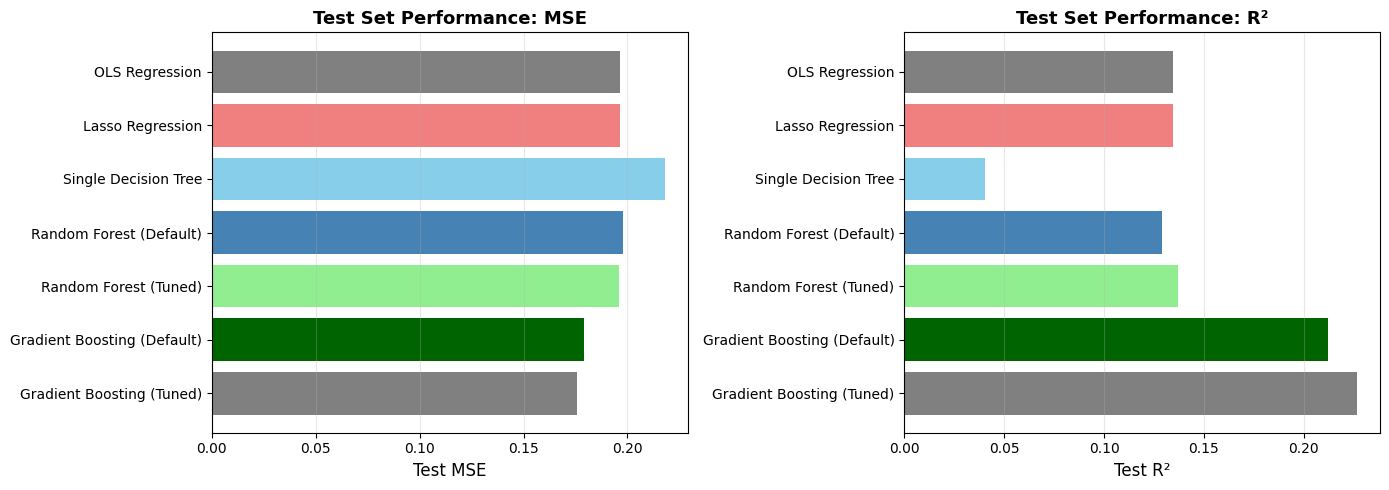


🏆 WINNER: Gradient Boosting (Tuned)
   Test MSE: 0.175615
   Test R²: 0.2268
   Improvement over naive: 10.7%


In [17]:
results = pd.DataFrame({
    'Model': [
        'OLS Regression',
        'Lasso Regression',
        'Single Decision Tree',
        'Random Forest (Default)',
        'Random Forest (Tuned)',
        'Gradient Boosting (Default)',
        'Gradient Boosting (Tuned)'
    ],
    'Test MSE': [
        ols_mse,
        lasso_mse,
        test_mse_tree,
        test_mse_rf,
        test_mse_rf_tuned,
        test_mse_gbm,
        test_mse_gbm_tuned
    ],
    'Test R²': [
        ols_r2,
        lasso_r2,
        test_r2_tree,
        test_r2_rf,
        test_r2_rf_tuned,
        test_r2_gbm,
        test_r2_gbm_tuned
    ]
})

# Improvement relative to OLS
results['Improvement (%)'] = (1 - results['Test MSE'] / ols_mse) * 100

print("📊 COMPREHENSIVE MODEL COMPARISON")
print("=" * 80)
print(results.to_string(index=False))
print("=" * 80)

# ---------------------------------------------------------
# Visual Comparison
# ---------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Test MSE comparison
axes[0].barh(
    results['Model'],
    results['Test MSE'],
    color=['gray', 'lightcoral', 'skyblue', 'steelblue', 'lightgreen', 'darkgreen']
)
axes[0].set_xlabel('Test MSE', fontsize=12)
axes[0].set_title('Test Set Performance: MSE', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3, axis='x')

# R² comparison
axes[1].barh(
    results['Model'],
    results['Test R²'],
    color=['gray', 'lightcoral', 'skyblue', 'steelblue', 'lightgreen', 'darkgreen']
)
axes[1].set_xlabel('Test R²', fontsize=12)
axes[1].set_title('Test Set Performance: R²', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Identify Best Model
# ---------------------------------------------------------

best_idx = results['Test MSE'].idxmin()
best_model = results.loc[best_idx, 'Model']
best_improvement = results.loc[best_idx, 'Improvement (%)']

print(f"\n🏆 WINNER: {best_model}")
print(f"   Test MSE: {results.loc[best_idx, 'Test MSE']:.6f}")
print(f"   Test R²: {results.loc[best_idx, 'Test R²']:.4f}")
print(f"   Improvement over naive: {best_improvement:.1f}%")


### Cross-validated model comparison

The single train/test split above has only ~38 test observations, making R² estimates highly variable. Below we use repeated 5-fold cross-validation to get more robust performance estimates with standard deviations.

In [ ]:
from sklearn.model_selection import cross_val_score, RepeatedKFold

cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# Define models to compare (using best hyperparameters found above)
cv_models = {
    "OLS (sklearn)": Pipeline([("scaler", StandardScaler()), 
                                ("lr", sm.OLS.__class__)]),  # placeholder
    "Lasso": Pipeline([("scaler", StandardScaler()), 
                       ("lasso", LassoCV(cv=5, random_state=42))]),
    "Decision Tree": DecisionTreeRegressor(random_state=42, min_samples_leaf=20),
    "Random Forest": RandomForestRegressor(
        n_estimators=500, max_features="sqrt", min_samples_leaf=10,
        random_state=42, n_jobs=-1),
    "GBM": GradientBoostingRegressor(
        n_estimators=1000, learning_rate=0.01, max_depth=5,
        min_samples_leaf=20, subsample=0.8, random_state=42)
}

# Use sklearn LinearRegression for OLS in CV (statsmodels doesn't integrate with cross_val_score)
from sklearn.linear_model import LinearRegression
cv_models["OLS"] = LinearRegression()
del cv_models["OLS (sklearn)"]

print("Cross-validated model comparison (5-fold x 3 repeats)")
print("=" * 70)

cv_results = []
for name, model in cv_models.items():
    scores_r2 = cross_val_score(model, X, y, cv=cv_strategy, scoring="r2", n_jobs=-1)
    scores_mse = -cross_val_score(model, X, y, cv=cv_strategy, scoring="neg_mean_squared_error", n_jobs=-1)
    cv_results.append({
        "Model": name,
        "CV R² (mean)": scores_r2.mean(),
        "CV R² (std)": scores_r2.std(),
        "CV MSE (mean)": scores_mse.mean(),
        "CV MSE (std)": scores_mse.std()
    })
    print(f"{name:20s}  R² = {scores_r2.mean():.4f} +/- {scores_r2.std():.4f}  |  MSE = {scores_mse.mean():.4f} +/- {scores_mse.std():.4f}")

cv_df = pd.DataFrame(cv_results)

# Plot CV R² with error bars
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(cv_df["Model"], cv_df["CV R² (mean)"], 
        xerr=cv_df["CV R² (std)"], color="steelblue", capsize=4)
ax.set_xlabel("Cross-Validated R²", fontsize=12)
ax.set_title("Model Comparison: Repeated 5-Fold Cross-Validation", fontsize=13, fontweight="bold")
ax.axvline(0, color="grey", linestyle="--", linewidth=0.8)
ax.invert_yaxis()
ax.grid(alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

print("\nNote: Error bars show 1 standard deviation across 15 CV folds.")
print("Overlapping bars suggest differences may not be statistically significant.")

## Permutation importance for tuned GBM

📊 Permutation Importance (GBM)
                             Feature    Importance      Std
                          price_2011  1.733594e-01 0.013973
                  pct_change_wfh_pct  1.045822e-02 0.001884
          pct_change_commute_bus_pct  3.372788e-03 0.001007
          pct_change_commute_car_pct  3.238401e-03 0.001032
                 transport_bank_mins  2.622390e-03 0.001390
         pct_change_not_deprived_pct  2.440605e-03 0.000874
              la_name_Waltham Forest  2.127746e-03 0.000406
    pct_change_commute_tube_rail_pct  1.917679e-03 0.000859
                       area_hectares  1.735589e-03 0.000595
                       la_name_Brent  1.549032e-03 0.000334
         pct_change_professional_pct  1.437342e-03 0.000574
                    pct_change_sales  1.360069e-03 0.000363
                healthy_assets_index  1.190925e-03 0.001772
pct_change_working_49ormorehours_pct  7.954702e-04 0.000490
    pct_change_working_16to48hrs_pct  7.273051e-04 0.000497
         

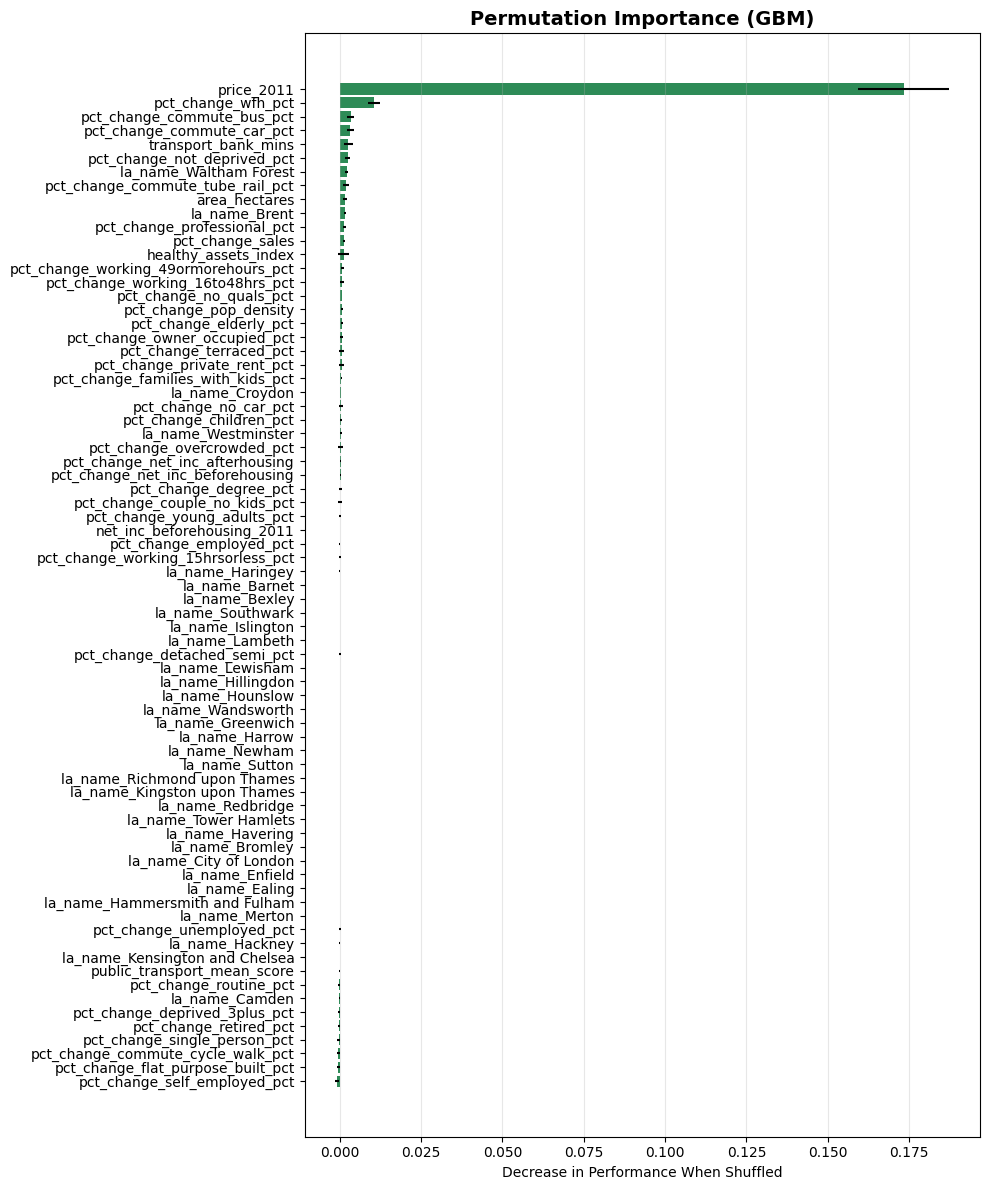

In [18]:
perm = permutation_importance(
    best_gbm,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='neg_mean_squared_error'
)

perm_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm.importances_mean,
    'Std': perm.importances_std
}).sort_values(by='Importance', ascending=False)

print("📊 Permutation Importance (GBM)")
print(perm_df.to_string(index=False))

# Plot
plt.figure(figsize=(10, 12))
plt.barh(perm_df['Feature'], perm_df['Importance'], xerr=perm_df['Std'], color='seagreen')
plt.gca().invert_yaxis()
plt.title("Permutation Importance (GBM)", fontsize=14, fontweight='bold')
plt.xlabel("Decrease in Performance When Shuffled")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


📊 Top Feature Importances (GBM)
                             Feature  Importance
                          price_2011    0.269511
                 transport_bank_mins    0.047972
                  pct_change_wfh_pct    0.044405
             pct_change_terraced_pct    0.031429
          pct_change_commute_car_pct    0.030609
          pct_change_commute_bus_pct    0.029227
                healthy_assets_index    0.026464
       pct_change_owner_occupied_pct    0.024574
    pct_change_commute_tube_rail_pct    0.022206
                    pct_change_sales    0.020966
          pct_change_overcrowded_pct    0.020473
pct_change_working_49ormorehours_pct    0.019224
         pct_change_private_rent_pct    0.018750
         pct_change_not_deprived_pct    0.018303
   pct_change_flat_purpose_built_pct    0.018146
         pct_change_professional_pct    0.017725
                       area_hectares    0.016992
              pct_change_pop_density    0.016707
    pct_change_working_16to48hrs_pct 

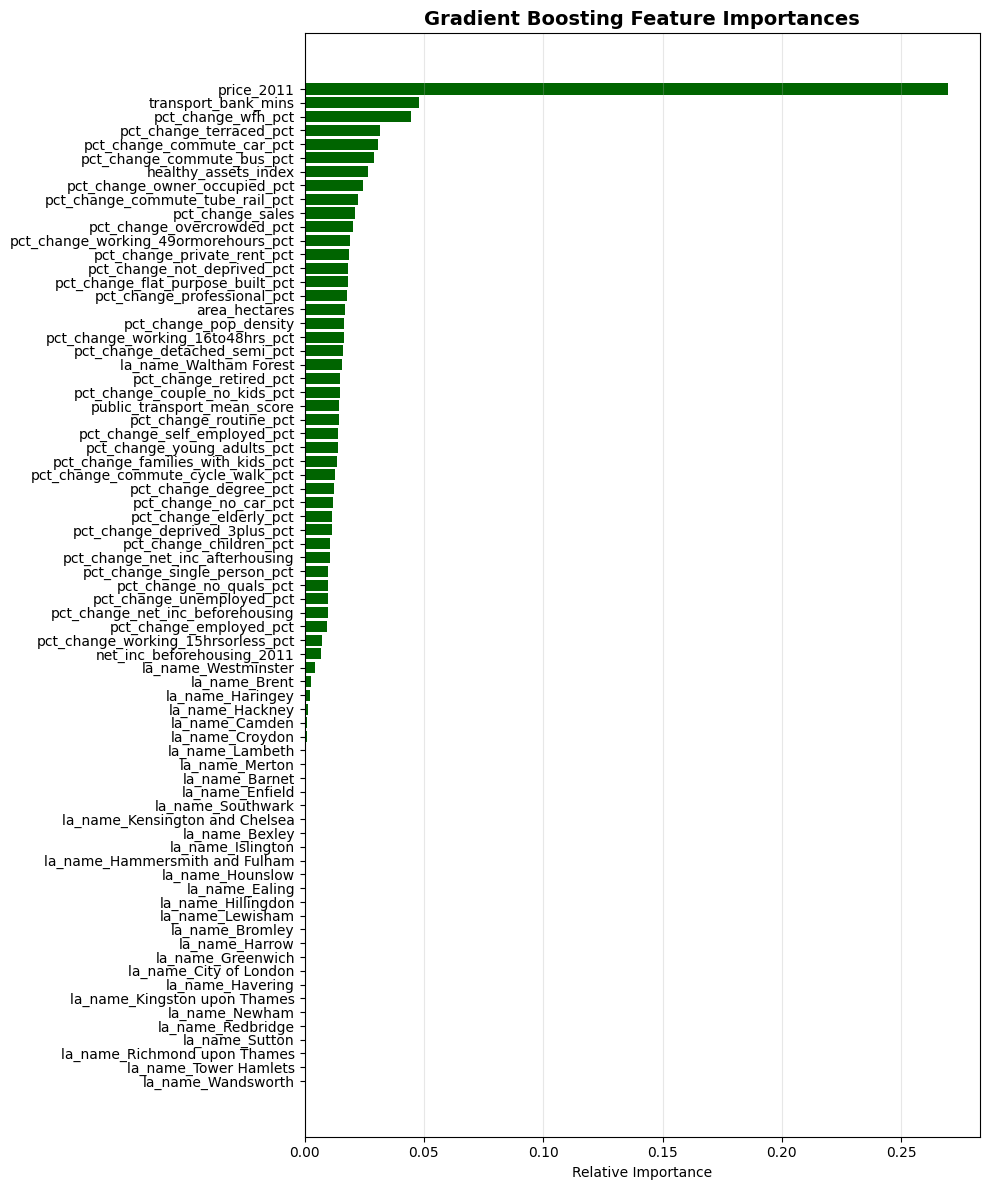

In [19]:
importances = best_gbm.feature_importances_
feature_names = X_train.columns

fi = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("📊 Top Feature Importances (GBM)")
print(fi.to_string(index=False))

# Plot
plt.figure(figsize=(10, 12))
plt.barh(fi['Feature'], fi['Importance'], color='darkgreen')
plt.gca().invert_yaxis()
plt.title("Gradient Boosting Feature Importances", fontsize=14, fontweight='bold')
plt.xlabel("Relative Importance")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


### Add a map of the residual differences

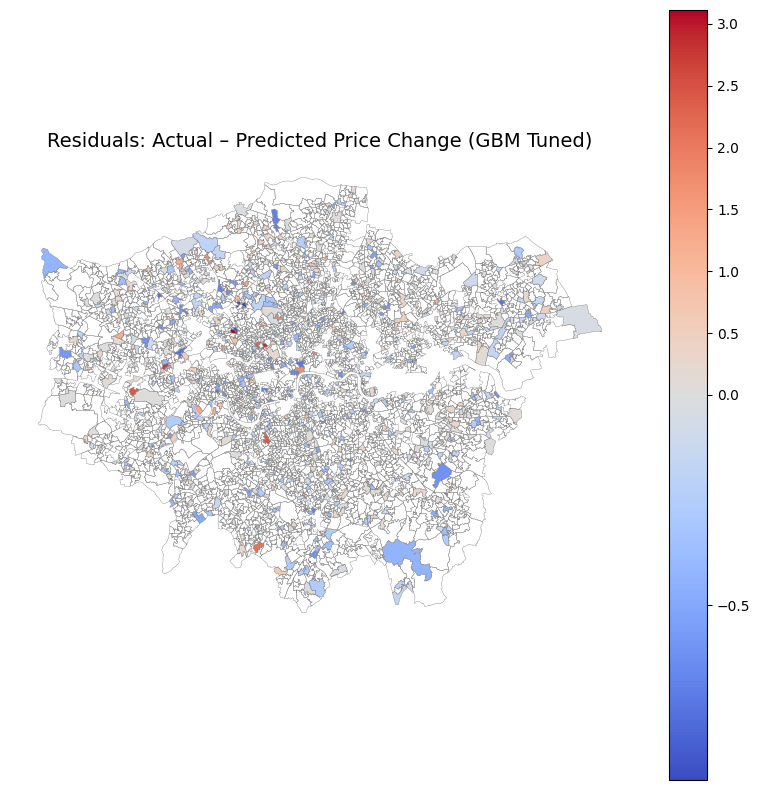

In [23]:
# ============================================================
# 1. Compute predictions and residuals
# ============================================================

y_pred_gbm = gbm_grid.predict(X_test)
residuals = y_test - y_pred_gbm

# Build a results table with LSOA codes
results_df = pd.DataFrame({
    "LSOA_code": df.loc[X_test.index, "lsoa_code"],
    "actual_price_change": y_test,
    "predicted_price_change": y_pred_gbm,
    "residual": residuals
})

# ============================================================
# 2. Load LSOA spatial boundaries
# ============================================================

import geopandas as gpd

lsoa_geo = gpd.read_file("LSOA_2011_EW_BFC_V3.shp")

# Rename shapefile column to match your df
lsoa_geo = lsoa_geo.rename(columns={"LSOA11CD": "LSOA_code"})

# ============================================================
# ⭐ NEW STEP: Filter shapefile to only LSOAs in your spreadsheet
# ============================================================

all_lsoas_in_spreadsheet = df["lsoa_code"].unique()

lsoa_geo_filtered = lsoa_geo[lsoa_geo["LSOA_code"].isin(all_lsoas_in_spreadsheet)]

# ============================================================
# 3. Merge model results with spatial data
# ============================================================

map_df = lsoa_geo_filtered.merge(results_df, on="LSOA_code", how="left")

# (Optional) If you ONLY want to colour LSOAs in the model:
# map_df = map_df[map_df["LSOA_code"].isin(results_df["LSOA_code"])]

# ============================================================
# 4. Plot residual map
# ============================================================

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot residuals around zero (only modelled LSOAs will have colour)
import matplotlib.colors as colors

norm = colors.TwoSlopeNorm(vcenter=0)

map_df.plot(
    column="residual",
    cmap="coolwarm",
    norm=norm,
    linewidth=0.1,
    edgecolor="grey",
    legend=True,
    ax=ax,
    missing_kwds={"color": "white", "label": "Not in model"}
)


# ⭐ Add boundary lines for ALL LSOAs in the spreadsheet
lsoa_geo_filtered.boundary.plot(ax=ax, color="grey", linewidth=0.2)

ax.set_title("Residuals: Actual – Predicted Price Change (GBM Tuned)", fontsize=14)
ax.axis("off")

plt.show()

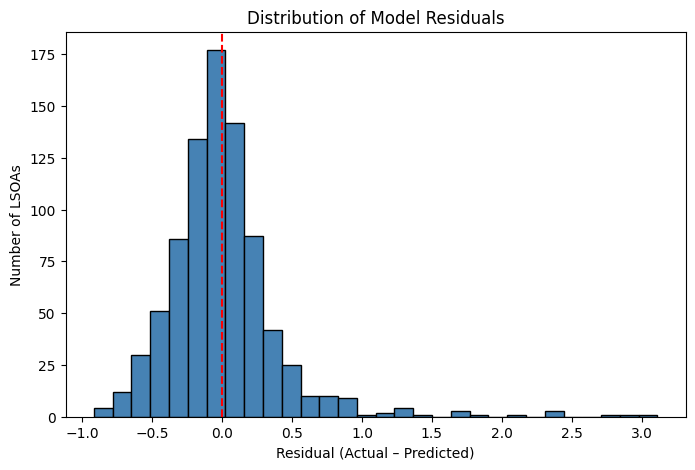

In [24]:
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color="steelblue", edgecolor="black")
plt.axvline(0, color="red", linestyle="--", linewidth=1.5)

plt.title("Distribution of Model Residuals")
plt.xlabel("Residual (Actual – Predicted)")
plt.ylabel("Number of LSOAs")

plt.show()


### Spatial autocorrelation of residuals (Moran's I)

Residuals from spatial data often exhibit spatial autocorrelation — neighbouring LSOAs tend to have similar residuals, violating the independence assumption. Moran's I tests whether residual patterns are spatially clustered.

In [ ]:
from libpysal.weights import Queen
from esda.moran import Moran

# Use the merged map_df which has both geometry and residuals
# Filter to only LSOAs with residual values (i.e., in the test set)
moran_df = map_df.dropna(subset=["residual"]).copy()

if len(moran_df) > 10:
    # Build spatial weights from queen contiguity
    w = Queen.from_dataframe(moran_df, use_index=False)
    w.transform = "r"  # row-standardise
    
    # Compute Moran's I
    mi = Moran(moran_df["residual"].values, w)
    
    print("Moran's I Test for Spatial Autocorrelation of Residuals")
    print("=" * 55)
    print(f"  Moran's I statistic: {mi.I:.4f}")
    print(f"  Expected I (random): {mi.EI:.4f}")
    print(f"  p-value (two-tailed): {mi.p_norm:.4f}")
    print(f"  z-score: {mi.z_norm:.4f}")
    print()
    if mi.p_norm < 0.05:
        print("  Result: Significant spatial autocorrelation detected (p < 0.05).")
        print("  This suggests residuals are spatially clustered, meaning the model")
        print("  systematically over- or under-predicts in certain areas of London.")
        print("  A spatial cross-validation strategy may be more appropriate.")
    else:
        print("  Result: No significant spatial autocorrelation (p >= 0.05).")
        print("  Residuals appear spatially random — the model does not systematically")
        print("  miss geographic patterns.")
else:
    print("Too few test-set LSOAs with spatial data to compute Moran's I.")

### Create PDPs

In [27]:
feature_names = X.columns
print(feature_names)

Index(['area_hectares', 'healthy_assets_index', 'price_2011',
       'public_transport_mean_score', 'net_inc_beforehousing_2011',
       'transport_bank_mins', 'pct_change_sales',
       'pct_change_owner_occupied_pct', 'pct_change_private_rent_pct',
       'pct_change_detached_semi_pct', 'pct_change_terraced_pct',
       'pct_change_flat_purpose_built_pct', 'pct_change_degree_pct',
       'pct_change_no_quals_pct', 'pct_change_employed_pct',
       'pct_change_self_employed_pct', 'pct_change_unemployed_pct',
       'pct_change_retired_pct', 'pct_change_professional_pct',
       'pct_change_routine_pct', 'pct_change_children_pct',
       'pct_change_young_adults_pct', 'pct_change_elderly_pct',
       'pct_change_not_deprived_pct', 'pct_change_deprived_3plus_pct',
       'pct_change_no_car_pct', 'pct_change_commute_tube_rail_pct',
       'pct_change_commute_bus_pct', 'pct_change_commute_car_pct',
       'pct_change_commute_cycle_walk_pct', 'pct_change_wfh_pct',
       'pct_change_single

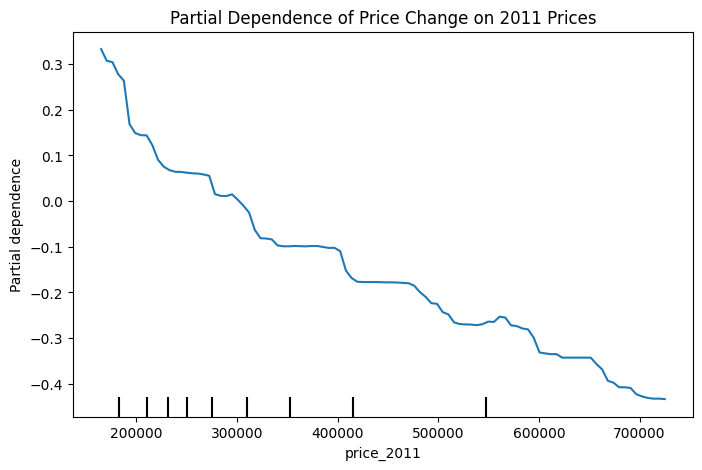

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))

PartialDependenceDisplay.from_estimator(
    gbm_grid.best_estimator_,
    X,
    features=["price_2011"],
    feature_names=feature_names,
    ax=ax
)

ax.set_title("Partial Dependence of Price Change on 2011 Prices")
plt.show()


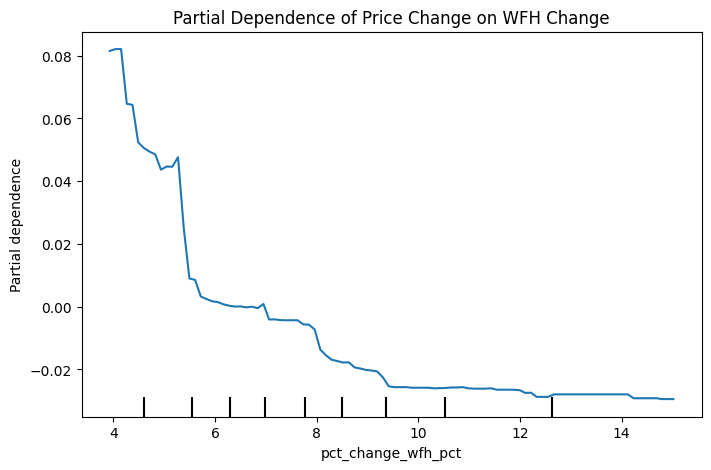

In [40]:
fig, ax = plt.subplots(figsize=(8, 5))

PartialDependenceDisplay.from_estimator(
    gbm_grid.best_estimator_,
    X,
    features=["pct_change_wfh_pct"],
    feature_names=feature_names,
    ax=ax
)

ax.set_title("Partial Dependence of Price Change on WFH Change")
plt.show()


### Heatmap of all london price changes

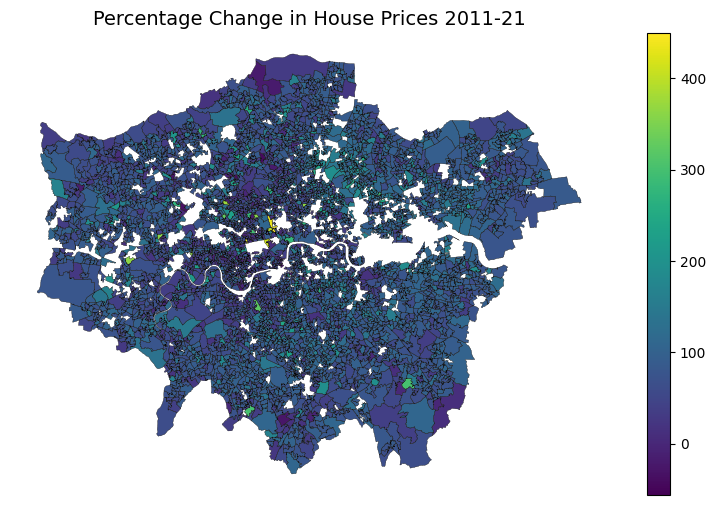

In [68]:
price_df = df[["lsoa_code", "pct_change_price"]].rename(columns={"lsoa_code": "LSOA_code"})

# Merge with spatial boundaries

map_price = lsoa_geo_filtered.merge(price_df, on="LSOA_code", how="left")  # convert to percentage

# Plot the heatmap

import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Optional: centre colour scale at zero (useful if some LSOAs declined)
#norm = colors.TwoSlopeNorm(vcenter=0)

map_price["pct_change_price_pct"] = map_price["pct_change_price"] * 100


fig, ax = plt.subplots(1, 1, figsize=(10, 6))


map_price.plot(
    column="pct_change_price_pct",
    cmap = "viridis",
    linewidth=0.1,
    edgecolor="grey",
    legend=True,
    ax=ax,
    missing_kwds={"color": "white", "label": "No data"}
)

lsoa_geo_filtered.boundary.plot(ax=ax, color="black", linewidth=0.2)

ax.set_title("Percentage Change in House Prices 2011-21", fontsize=14)
ax.axis("off")

plt.show()



### Limitations and caveats

**1. Simultaneity / Endogeneity.** All percentage-change features span the same 2011-2021 window as the dependent variable. The analysis therefore captures *associations*, not *causal* or *forecasting* relationships. Reverse causality is likely for several features (e.g., rising prices may drive out families rather than the converse). A lagged specification (2001-2011 changes predicting 2011-2021 outcomes) would be needed for causal inference.

**2. Sample size vs. dimensionality.** With ~189 LSOAs and ~72 features (including borough dummies), the observation-to-feature ratio (~2.6:1) is well below the conventional 10-20:1 guideline. This constrains the reliability of OLS coefficient estimates and may contribute to the modest R² values across all models.

**3. Sample representativeness.** The dataset covers approximately 3.9% of London's ~4,835 LSOAs (2011 boundaries). The selection criteria for which LSOAs are included are not documented. Results should therefore be interpreted as applying to this sample, not generalised to London as a whole without further validation.

**4. Spatial leakage.** The random train/test split does not account for spatial proximity. Neighbouring LSOAs that share local market conditions may appear in both the training and test sets, potentially inflating apparent model performance. Spatial cross-validation (e.g., leave-one-borough-out) would provide a more conservative estimate.

**5. COVID-19 endpoint effects.** The 2021 endpoint of the analysis coincides with the COVID-19 pandemic, which caused significant short-term distortions in housing markets (stamp duty holiday, remote work shifts, urban-to-suburban migration). Percentage changes ending in 2021 may not reflect long-run structural trends.

**6. No outlier treatment.** Some features exhibit extreme percentage changes (e.g., -100% indicating complete disappearance of a housing type in an LSOA). These were retained without winsorisation or investigation, which may influence regression-based models disproportionately.

**7. Multicollinearity.** Several features are structurally correlated (e.g., employment categories summing to 100%, commute mode shares summing to 100%). The VIF analysis above quantifies this. While tree-based models are relatively robust to collinearity, it makes individual feature importance rankings less stable and OLS coefficient estimates unreliable.